## Final Project Submission

Please fill out:
* Student name: Christopher Hollman
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@chollman91/weather-analysis-of-colbert-wa-for-june-11th-from-1970-2021-63671b0c0061


# Project Overview:

The country of Tanzania is partially dependent on a number of outside organizations and governments to supply water to the country's population. Since these water sources are funded, installed, and maintained by a number of different parties, it is a logistical challenge to oversee them all and anticipate which areas are in need of repair or replacement. This project aims to use machine learning to identify sources that are non functional or failing so that the Government of Tanzania can efficiently direct their limited resources to the areas that need them most. 

## Project Goals: 

To build a classification model that significantly outperforms a baseline decision tree "stump" model in terms of precision and recall for the target classification group (1). These values are important as we want to be able to detect and classify a high percentage of the total failed waterpoints, but also don't want to waste government resources investigating fully functional waterpoints that have been incorrectly tagged as non functional.

In [619]:
#importing necessary tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [620]:
training_labels = pd.read_csv('data/training_set_labels.csv')
training_values = pd.read_csv('data/training_set_values.csv')
combined_df = training_labels.merge(training_values)


In [621]:
combined_df.shape

(59400, 41)

In [622]:
training_values['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

## Initial Data Exploration:
The target variable for this dataset is currently split into three categories. For our purposes
any source that is not labeled as functional will need attention, eliminating the need to delineate
between the two other categories.

In [623]:
training_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [624]:
#Converting 3 labels into binary categories. 
label_conversions = {
    'functional':0,
    'functional needs repair':1,
    'non functional':1
}
y = training_labels['status_group'].replace(label_conversions) 

## Exploration of Predictors:
There are quite a few categories that seem to be very similar to one another if not redundant.
We will drop a number of these to simplify our model.

In [625]:
training_values.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [664]:
#These columns are either duplicates or more poorly categorized versions of columns that we kept

unusable_columns = ['id','date_recorded', 'wpt_name', 'num_private', 
                    'subvillage','lga', 'ward', 
                    'recorded_by', 'extraction_type_group', 'extraction_type', 
                    'scheme_name', 'management', 'waterpoint_type_group', 
                    'source', 'source_class', 'quantity_group', 'quality_group', 
                    'payment_type', 'latitude', 'longitude']

In [665]:
X_vals = training_values.drop(unusable_columns, axis=1)
X_vals.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'region_code', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_type', 'waterpoint_type'],
      dtype='object')

In [666]:
X_vals.isna().sum()

amount_tsh                  0
funder                   3635
gps_height                  0
installer                3655
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type_class       0
management_group            0
payment                     0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

### Funder/Installer Columns:
These columns posed a challenge in that they appear to have been entered manually, resulting in
extremely high cardinality and many entries that are close to one another but misspelled or abbreviated.
I limited my categories to the top 30, cleaned those entries up as best I could and categorized the rest as 'other'

In [667]:
top_installers = set(X_vals['installer'].value_counts().index[:30].values)
top_funders = set(X_vals['funder'].value_counts().index[:30].values)
print(top_installers)
print(top_funders)

{'HESAWA', 'RWE', 'SEMA', 'WU', 'TASAF', 'Hesawa', 'District Council', 'TCRS', 'World Vision', 'Gover', 'Commu', 'DANIDA', 'Central government', 'Government', 'WEDECO', '0', 'DANID', 'Dmdd', 'AMREF', 'OXFAM', 'Community', 'KKKT', 'TWESA', 'DW', 'CES', 'World vision', 'LGA', 'District council', 'DWE', 'ACRA'}
{'Hifab', 'World Bank', 'Ministry Of Water', 'Government Of Tanzania', 'Rc Church', 'Tasaf', 'Rwssp', 'Fini Water', 'Hesawa', 'Amref', 'District Council', 'Unicef', 'Netherlands', 'World Vision', 'Wateraid', 'Dwsp', '0', 'Germany Republi', 'Dhv', 'Adb', 'Private Individual', 'Lga', 'Danida', 'Kkkt', 'Dwe', 'Water', 'Tcrs', 'Isf', 'Norad', 'Oxfam'}


In [668]:
#combining similar labels within top 30 and replacing remaining values with 'other'

installer_replace = {
    'Commu':'Community',
    '0':'Unknown',
    'DANID':'DANIDA',
    'District council':'District Council',
    'DW':'DWE',
    'Gov':'Government',
    'Gover':'Government',
    'Central Government':'Government',
    'HESAWA':'Hesawa',
    'World vision':"World Vision"
}

X_vals['installer'].replace(installer_replace, inplace=True)

X_vals['funder'].replace('0','Unknown', inplace=True)

top_installers = set(X_vals['installer'].value_counts().index[:30].values)
top_funders = set(X_vals['funder'].value_counts().index[:30].values)

In [669]:
for i in X_vals.index: 
    if X_vals['installer'][i] not in top_installers:
        X_vals['installer'][i] = 'Other'

for i in X_vals.index: 
    if X_vals['funder'][i] not in top_funders:
        X_vals['funder'][i] = 'Other'     

In [670]:
X_vals['funder'].value_counts()

Other                     26129
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
District Council            843
Dhv                         829
Private Individual          826
Dwsp                        811
Unknown                     781
Norad                       765
Germany Republi             610
Tcrs                        602
Ministry Of Water           590
Water                       583
Dwe                         484
Netherlands                 470
Hifab                       450
Adb                         448
Lga                         442
Amref                       425
Fini Water                  393
Oxfam                       359
Wateraid                    333
Rc Church                   321
Isf                         316
Name: fu

In [671]:
X_vals['installer'].value_counts()

Other                         23679
DWE                           17648
Government                     2318
Community                      1613
DANIDA                         1602
Hesawa                         1379
RWE                            1206
District Council                943
KKKT                            898
Unknown                         780
TCRS                            707
World Vision                    678
Central government              622
CES                             610
LGA                             408
WEDECO                          397
TASAF                           396
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
SEMA                            249
OXFAM                           234
Da                              224
Idara ya maji                   222
UNICEF                          222
Gove                        

In [672]:
#At this point we will also categorize unknown scheme management values as such

X_vals['scheme_management'].fillna('Unknown', inplace=True)
X_vals['scheme_management'].replace('None', 'Unknown', inplace=True)

### Dealing with missing values:
At this point we will execute our train test split, as the imputed values here will otherwise cause potential data leakage when modeling.There are quite a few missing values, each of which we will deal with in a slightly different way. For construction year we will take the median of the dataset excluding zero values (2000) and replace any zeros with this number. For scheme management we will label these values as 'unknown'. For funder and installer we will list them with the majority of the values as 'other'. I used the 'pad' method for public meeting and permit in order to preserve the ratio of yes/no values.

In [673]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(X_vals, y, test_size=.30, random_state=2)



In [674]:
X_train.isna().sum()

amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
public_meeting           2300
scheme_management           0
permit                   2134
construction_year           0
extraction_type_class       0
management_group            0
payment                     0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

In [675]:
print('gps_height zeros:', len(X_train[X_train['gps_height']==0]))
print('constuction_year zeroes:', len(X_train[X_train['construction_year']==0]))
print('population zeroes:', len(X_train[X_train['population']==0]))

#these gps height values seem unlikely to be accurate, which can be explored in later versions of the model

gps_height zeros: 14312
constuction_year zeroes: 14540
population zeroes: 15009


In [676]:
#Zeros seem to be okay here, as most of are values are quite low, indicating that this is likely a real number
#rather than a numerical placeholder.

X_train['population'].describe()

count    41580.000000
mean       181.191053
std        488.833915
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [677]:
#replacing unknown construction years with median value

print(X_train['construction_year'].value_counts())
non_zero_median = X_train[X_train['construction_year']!=0]['construction_year'].median()
X_train['construction_year'].replace(0,non_zero_median, inplace=True)
X_test['construction_year'].replace(0,non_zero_median, inplace=True)

0       14540
2010     1875
2008     1847
2009     1755
2000     1437
2007     1122
2006     1026
2003      870
2011      867
2004      803
2012      762
1995      745
1978      738
2002      731
2005      720
1999      692
1998      679
1990      669
1985      616
1996      574
1980      554
1984      537
1982      513
1972      507
1994      494
1974      465
1997      454
1992      435
1993      417
2001      376
1988      365
1983      358
1986      311
1975      300
1976      290
1970      281
1991      235
1989      219
1987      204
1981      178
1979      141
1977      132
2013      129
1973      125
1971       96
1960       78
1967       69
1963       66
1968       59
1969       39
1964       27
1962       19
1961       14
1966       13
1965       12
Name: construction_year, dtype: int64


In [678]:
#padding true/false categories and converting to integers

X_train['public_meeting'] = X_train['public_meeting'].fillna(method='pad').astype(int)
X_test['public_meeting'] = X_test['public_meeting'].fillna(method='pad').astype(int)


X_train['permit'] = X_train['permit'].fillna(method='pad').astype(int)
X_test['permit'] = X_test['permit'].fillna(method='pad').astype(int)


In [679]:
#replacing unknown construction years with median value

print(X_train['construction_year'].value_counts())
non_zero_median = X_train[X_train['construction_year']!=0]['construction_year'].median()
X_train['construction_year'].replace(0,non_zero_median, inplace=True)
X_test['construction_year'].replace(0,non_zero_median, inplace=True)

2000    15977
2010     1875
2008     1847
2009     1755
2007     1122
2006     1026
2003      870
2011      867
2004      803
2012      762
1995      745
1978      738
2002      731
2005      720
1999      692
1998      679
1990      669
1985      616
1996      574
1980      554
1984      537
1982      513
1972      507
1994      494
1974      465
1997      454
1992      435
1993      417
2001      376
1988      365
1983      358
1986      311
1975      300
1976      290
1970      281
1991      235
1989      219
1987      204
1981      178
1979      141
1977      132
2013      129
1973      125
1971       96
1960       78
1967       69
1963       66
1968       59
1969       39
1964       27
1962       19
1961       14
1966       13
1965       12
Name: construction_year, dtype: int64


## Fitting Decision Tree Model:
The model we will use as a baseline will be Decision tree limited to a max depth of 3. This is a relatively simple model that is commonly used for baseline scores.

In [680]:
categoricals = [ 
    'installer', 
    'funder', 
    'basin',
    'region',
    'scheme_management',
    'extraction_type_class',
    'management_group',
    'payment',
    'quantity',
    'source_type',
    'waterpoint_type',
    'water_quality'
]        

In [681]:
X_test[categoricals].isna().sum()

installer                0
funder                   0
basin                    0
region                   0
scheme_management        0
extraction_type_class    0
management_group         0
payment                  0
quantity                 0
source_type              0
waterpoint_type          0
water_quality            0
dtype: int64

In [682]:
#one hot encoding categorical values

ohe = OneHotEncoder()

# passing categorical columns
ohe.fit(X_train[categoricals])
X_train_ohe = ohe.transform(X_train[categoricals]).toarray()

In [683]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names(categoricals), index = X_train.index)

In [684]:
X_train.drop(categoricals, axis=1, inplace=True)
X_train_ohe = pd.concat([X_train_ohe, X_train], axis=1)

In [685]:
#one hot encoding categorical values

ohe = OneHotEncoder()

# passing categorical columns
ohe.fit(X_test[categoricals])
X_test_ohe = ohe.transform(X_test[categoricals]).toarray()

In [686]:
X_test_ohe = pd.DataFrame(X_test_ohe, columns = ohe.get_feature_names(categoricals), index = X_test.index)

In [687]:
X_test.drop(categoricals, axis=1, inplace=True)
X_test_ohe = pd.concat([X_test_ohe, X_test], axis=1)

In [698]:
# Fitting Decision Tree
clf_dt = DecisionTreeClassifier(max_depth=3)
clf_dt.fit(X_train_ohe, y_train)
 
print('Untuned Decision Tree Scores:\n', classification_report(y_test,clf_dt.predict(X_test_ohe)))
print('Training Scores:------------------------------------------------------  \n', 
      classification_report(y_train,clf_dt.predict(X_train_ohe)))

Untuned Decision Tree Scores:
               precision    recall  f1-score   support

           0       0.68      0.90      0.77      9647
           1       0.81      0.49      0.61      8173

    accuracy                           0.71     17820
   macro avg       0.74      0.70      0.69     17820
weighted avg       0.74      0.71      0.70     17820

Training Scores:------------------------------------------------------  
               precision    recall  f1-score   support

           0       0.68      0.90      0.77     22612
           1       0.80      0.49      0.61     18968

    accuracy                           0.71     41580
   macro avg       0.74      0.69      0.69     41580
weighted avg       0.73      0.71      0.70     41580



#### Baseline Decision Tree Performance:
The metrics to focus on are precision and recall for 1 values. This model has .81 precision, meaning that
it is correct 81% of the time when it predicts that a water sources is in need or repair or replacement. The .49 recall score indicates that this model correctly identifies only 49% of total sources that are in our target category. Similar train/test scores suggest the model is avoiding and major over or under fitting. This is a serviceable baseline model but can certainly be improved.

In [699]:

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 15, 20, 25, 30],
    'min_samples_split': [10, 12, 14, 15, 16, 17]
}

gs_tree = GridSearchCV(clf_dt, param_grid_dt, cv=3)
gs_tree.fit(X_train_ohe, y_train)

print(gs_tree.best_params_)
print(gs_tree.best_score_)

{'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 16}
0.775901875901876


In [700]:
clf_dt_2 = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=25, 
    min_samples_split=16
)
clf_dt_2.fit(X_train_ohe, y_train)
print('Tuned Decison Tree Scores: \n', classification_report(y_test,clf_dt_2.predict(X_test_ohe)))
print('Training Scores:------------------------------------------------------  \n', 
      classification_report(y_train,clf_dt_2.predict(X_train_ohe)))

Tuned Decison Tree Scores: 
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      9647
           1       0.79      0.71      0.75      8173

    accuracy                           0.78     17820
   macro avg       0.79      0.78      0.78     17820
weighted avg       0.78      0.78      0.78     17820

Training Scores:------------------------------------------------------  
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     22612
           1       0.89      0.79      0.84     18968

    accuracy                           0.86     41580
   macro avg       0.87      0.86      0.86     41580
weighted avg       0.86      0.86      0.86     41580



### Tuned Decision Tree Performance:
With these tuned parameters our model is less precise (79%) when categorizing a source as in need of repair, but has gained performance in terms of detecting more sources that should be flagged as in need of service. The overall accuracy of the model improved marginally but these parameters do seem to over fit the data slightly. 

## Fitting a Random Forest Model:
Given the amount of noise present in our data, it is likely that we can improve our model by fitting a random
forest model made up of a consensus of many simple decision trees. 

In [704]:
#fit random forest 
clf_rf = RandomForestClassifier(random_state=42) 
clf_rf.fit(X_train_ohe,y_train)
print('Random Forest Scores \n', classification_report(y_test,clf_rf.predict(X_test_ohe)))
print('Training Scores:------------------------------------------------------  \n', 
      classification_report(y_train,clf_rf.predict(X_train_ohe)))


Random Forest Scores 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      9647
           1       0.81      0.76      0.78      8173

    accuracy                           0.81     17820
   macro avg       0.81      0.80      0.81     17820
weighted avg       0.81      0.81      0.81     17820

Training Scores:------------------------------------------------------  
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     22612
           1       0.96      0.94      0.95     18968

    accuracy                           0.96     41580
   macro avg       0.96      0.95      0.95     41580
weighted avg       0.96      0.96      0.96     41580



### Untuned Random Forest Performance:
This more complex model resulted in a similar precision for our target category without the drop off in recall as well as better overall accuracy. This is already a good improvement over decision trees, but we appear to be severely over fitting.

In [706]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [1, 3, 5]
}


gs_forest = GridSearchCV(clf_rf, param_grid_rf, cv=3)
gs_forest.fit(X_train_ohe, y_train)

print(gs_forest.best_params_)
print(gs_forest.best_estimator_)
print(gs_forest.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=150, random_state=42)
0.812049062049062


In [716]:
clf_rf_2 = RandomForestClassifier(
    n_estimators=150,
    criterion='entropy',
    max_depth=None,
    min_samples_split = 10,
    min_samples_leaf = 1,
    random_state=42) 
clf_rf_2.fit(X_train_ohe, y_train)
print('Tuned Random Forest Scores \n', classification_report(y_test,clf_rf_2.predict(X_test_ohe)))
print('Training Scores:------------------------------------------------------  \n', 
      classification_report(y_train,clf_rf_2.predict(X_train_ohe)))


Tuned Random Forest Scores 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      9647
           1       0.82      0.75      0.79      8173

    accuracy                           0.81     17820
   macro avg       0.81      0.81      0.81     17820
weighted avg       0.81      0.81      0.81     17820

Training Scores:------------------------------------------------------  
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     22612
           1       0.92      0.86      0.88     18968

    accuracy                           0.90     41580
   macro avg       0.90      0.89      0.90     41580
weighted avg       0.90      0.90      0.90     41580



# Tuned Random Forest Performance: 
We were able to increase the precision of our model for our target category by 1 point at the cost of 1 point of recall, which is somewhat acceptable. Overall model accuracy remained the same. We have reduced over fitting but it still does seem to be an issue

## Fitting XG Boost Model
This tends to be one of the more accurate models readily available for classification tasks. It should perform similarly or better as compared to the Random Forest model. 

In [717]:
# XGBoost
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train_ohe,y_train)
print('XG Boost Scores \n', classification_report(y_test,clf_xgb.predict(X_test_ohe)))
print('Training Scores:------------------------------------------------------  \n', 
      classification_report(y_train,clf_xgb.predict(X_train_ohe)))


XG Boost Scores 
               precision    recall  f1-score   support

           0       0.78      0.88      0.83      9647
           1       0.83      0.72      0.77      8173

    accuracy                           0.80     17820
   macro avg       0.81      0.80      0.80     17820
weighted avg       0.81      0.80      0.80     17820

Training Scores:------------------------------------------------------  
               precision    recall  f1-score   support

           0       0.82      0.91      0.86     22612
           1       0.88      0.75      0.81     18968

    accuracy                           0.84     41580
   macro avg       0.85      0.83      0.84     41580
weighted avg       0.85      0.84      0.84     41580



### Untuned XG Boost Model Performance:
An untuned XB Boost model results in lightly better precision but lower recall and accuracy scores than our tuned random forest.

In [718]:
param_grid_xgb = {
    'learning_rate': [0.1, .2, .3],
    'max_depth': [2,4,6],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [100, 150, 200]
}

In [38]:
gs_boost = GridSearchCV(clf_xgb, param_grid_xgb, cv=3)
gs_boost.fit(X_train_ohe, y_train)
print(gs_boost.best_params_)
print(gs_boost.best_estimator_)
print(gs_boost.best_score_)

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.8042648709315378


In [719]:
clf_xgb_2 = XGBClassifier(learning_rate=0.3, max_depth= 6, n_estimators= 200, subsample=0.7)
clf_xgb_2.fit(X_train_ohe, y_train)
print('Tuned XG Boost Scores \n', classification_report(y_test,clf_xgb_2.predict(X_test_ohe)))
print('Training Scores:------------------------------------------------------  \n', 
      classification_report(y_train,clf_xgb_2.predict(X_train_ohe)))


Tuned XG Boost Scores 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      9647
           1       0.82      0.75      0.78      8173

    accuracy                           0.81     17820
   macro avg       0.81      0.80      0.80     17820
weighted avg       0.81      0.81      0.81     17820

Training Scores:------------------------------------------------------  
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     22612
           1       0.89      0.81      0.85     18968

    accuracy                           0.87     41580
   macro avg       0.87      0.86      0.87     41580
weighted avg       0.87      0.87      0.87     41580



### Tuned XG Boost Model Performance:
None of the parameters in the grid search resulted in appreciably better performance. The tuned Random Forest and XGBoost models were very similar in terms of performance and have the best mix of precision and recall for the target group, meaning that a good portion of failures are being correctly categorized without wasting government resources investigating wells that are actually working properly. 

In [736]:
importances = clf_rf_2.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

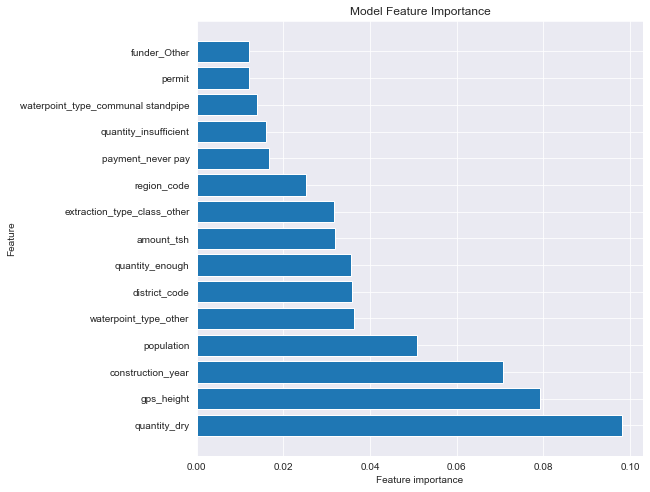

In [733]:
def plot_feature_importances(model):
    sns.set_style('darkgrid')
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    n_features = 15
    plt.figure(figsize=(8,8))
    plt.barh(range(15), importances[sorted_indices][:15], align='center') 
    plt.yticks(range(15), X_train_ohe.columns[sorted_indices][:15])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Model Feature Importance')
plot_feature_importances(clf_rf_2)

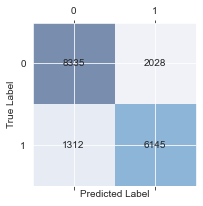

In [735]:
y_pred = clf_rf_2.predict(X_test_ohe)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig,ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
for x in range(confmat.shape[0]):
    for y in range(confmat.shape[1]):
        ax.text(x=x,y=y,
               s=confmat[x,y],
               va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Interpretation:
The most important features for this model are the waterpoint being categorized as dry, the altitude of the well and the year it was built/installed. There are quite a few 0 values in the GPS height column so looking deeper into the accuracy of those numbers may be useful to improve model performance. Also interestingly, not all of the waterpoints that are described as "dry" are labeled as non functional. 

## Conclusion/Next Steps: 
This model is able to accurately categorize a failing/failed water source 82% of the time, while detecting 75 percent of the total sources in need of repair or replacement. This is a good starting point and results in a much more efficient approach compared to a nationwide routine inspection of all wells. The major limitations of this model lie with the data itself and some improvement in performance could be gained by:
1. Reclassifying/aggregating the extensive list of funders/installers.
2. Looking deeper into GPS height, which was one of our top features in terms of performance.
3. Ranking flagged sites in terms of urgency.

## Graphing Data

In [32]:
regions = combined_df.groupby('region')['status_group'].value_counts().unstack()
regions['total'] = regions['non functional']+regions['functional needs repair']+regions['functional']
regions['failure_rate'] = (regions['non functional']+regions['functional needs repair'])/regions['total']
regions = regions.sort_values('failure_rate', ascending=False)

In [227]:
regions.reset_index(inplace=True)

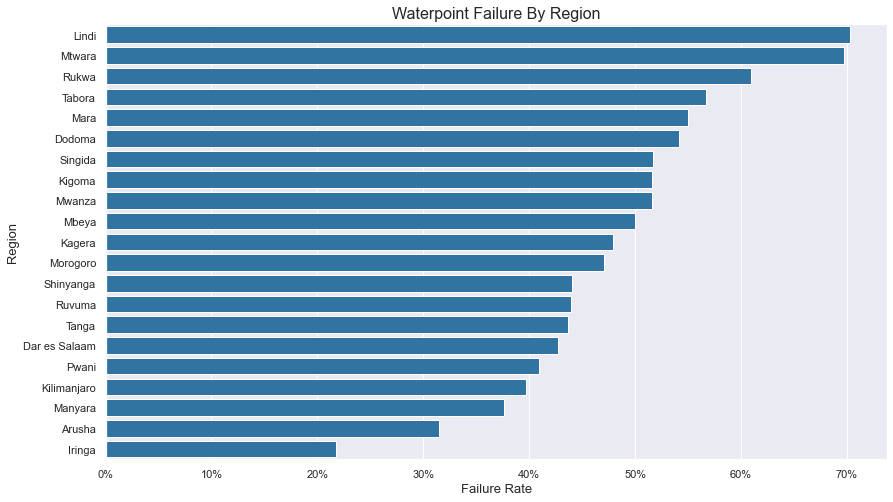

In [245]:
ax = plt.subplots(figsize=(14,8))
sns.set_theme(style="darkgrid")
sns.set()
ax = sns.barplot(
    y = regions['region'], 
    x = regions['failure_rate']*100, 
    color = "tab:blue",
    data = regions, orient="h")
ax.set_xlabel("Failure Rate", fontsize=13)
ax.set_ylabel("Region", fontsize=13)
ax.set_title("Waterpoint Failure By Region", fontsize=16)
    
ax.xaxis.set_major_formatter(mtick.PercentFormatter());


In [739]:
combined_df['amount_tsh'].describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [748]:
combined_df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [745]:
quantities = combined_df.groupby('quantity')['status_group'].value_counts().unstack()
quantities['total'] = quantities['non functional']+quantities['functional needs repair']+quantities['functional']
quantities['failure_rate'] = (quantities['non functional']+quantities['functional needs repair'])/quantities['total']
quantities = quantities.sort_values('failure_rate', ascending=False)

In [751]:
quantities.reset_index(inplace=True)

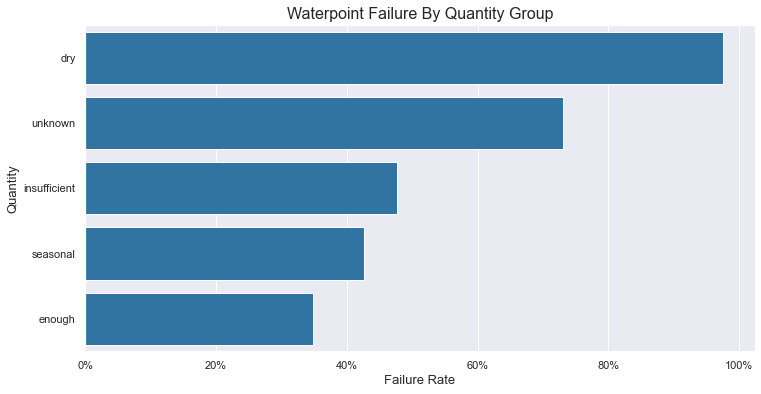

In [753]:
ax = plt.subplots(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set()
ax = sns.barplot(
    y = quantities['quantity'], 
    x = quantities['failure_rate']*100, 
    color = "tab:blue",
    data = quantities, orient="h")
ax.set_xlabel("Failure Rate", fontsize=13)
ax.set_ylabel("Quantity", fontsize=13)
ax.set_title("Waterpoint Failure By Quantity Group", fontsize=16)
    
ax.xaxis.set_major_formatter(mtick.PercentFormatter());

In [814]:
combined_df.loc[combined_df['gps_height'] >=0, 'height_group'] = '0-500' 
combined_df.loc[combined_df['gps_height'] >=500, 'height_group'] = '500-1000'
combined_df.loc[combined_df['gps_height'] >=1000, 'height_group'] = '1000-1500'
combined_df.loc[combined_df['gps_height'] >=1500, 'height_group'] = '1500-2000'
combined_df.loc[combined_df['gps_height'] >=2000, 'height_group'] = '2000-2500'
combined_df.loc[combined_df['gps_height'] >=2500, 'height_group'] = '2500-3000'

In [817]:
alts = combined_df.groupby('height_group')['status_group'].value_counts().unstack()
alts['total'] = alts['non functional']+alts['functional needs repair']+alts['functional']
alts['failure_rate'] = (alts['non functional']+alts['functional needs repair'])/alts['total']
alts = alts.sort_values('failure_rate', ascending=False)
alts.reset_index(inplace=True)

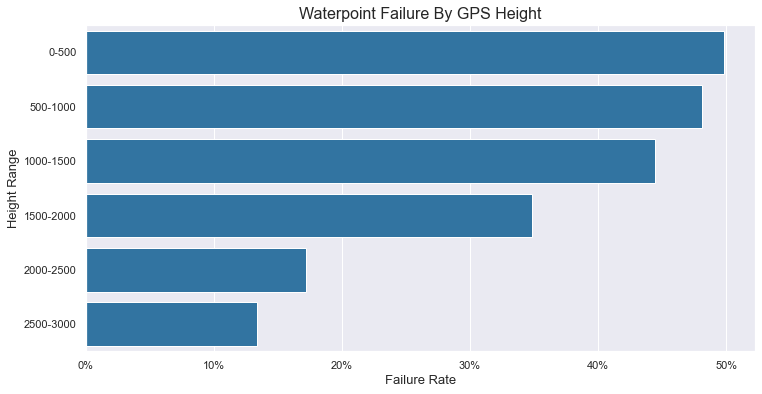

In [819]:
ax = plt.subplots(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set()
ax = sns.barplot(
    y = alts['height_group'], 
    x = alts['failure_rate']*100, 
    color = "tab:blue",
    data = alts, orient="h")
ax.set_xlabel("Failure Rate", fontsize=13)
ax.set_ylabel("Height Range", fontsize=13)
ax.set_title("Waterpoint Failure By GPS Height", fontsize=16)
    
ax.xaxis.set_major_formatter(mtick.PercentFormatter());

In [821]:
types = combined_df.groupby('waterpoint_type')['status_group'].value_counts().unstack()
types['total'] = types['non functional']+types['functional needs repair']+types['functional']
types['failure_rate'] = (types['non functional']+types['functional needs repair'])/types['total']
types = types.sort_values('failure_rate', ascending=False)
types.reset_index(inplace=True)

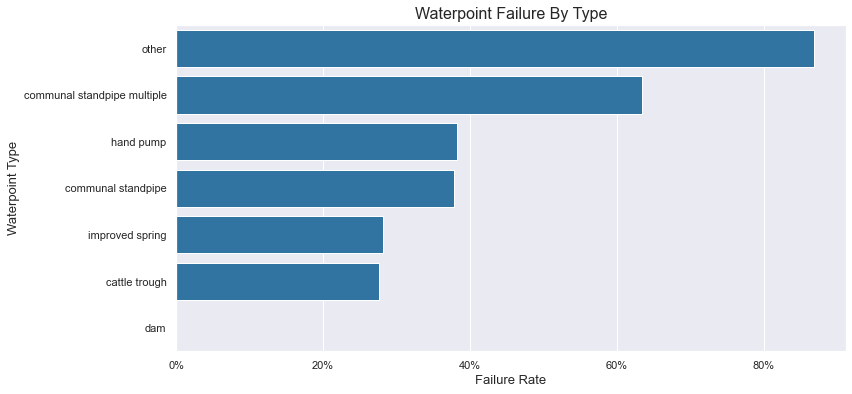

In [824]:
ax = plt.subplots(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set()
ax = sns.barplot(
    y = types['waterpoint_type'], 
    x = types['failure_rate']*100, 
    color = "tab:blue",
    data = types, orient="h")
ax.set_xlabel("Failure Rate", fontsize=13)
ax.set_ylabel("Waterpoint Type", fontsize=13)
ax.set_title("Waterpoint Failure By Type", fontsize=16)
    
ax.xaxis.set_major_formatter(mtick.PercentFormatter());